## **CNN Model with Data Augmentation Techniques**

# Importing necessary Libraries and Modules

*Conv2D, Dense, Flatten, Input, MaxPooling2D from tensorflow.keras.layers: These are the layers whixh are used to build the neural networks*

*plot_model from tensorflow.keras.utils: This function is used to visualize the neural network model architecture*

*train_test_split from sklearn.model_selection:  This is Used to split the dataset into training and testing sets.
compute_class_weight from sklearn.utils: is used to calculate weights for the classes when dealing with imbalanced datasets.*

In [6]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

from functools import partial
from keras import backend as K
from keras import callbacks
from sklearn.metrics import auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, losses, models
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

# Loading the CSV File

*pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv"): This line reads a CSV file located at the specified path ("/Downloads/archive/Folds.csv") into a Pandas DataFrame called folds* <br> *pd.DataFrame(folds.iloc[:7909]): This creates a new DataFrame df that contains only the first 7909 rows of the original folds DataFrame.* <br> *df['label'].str.strip(): This removes any leading or trailing whitespace characters from each entry in the label column.*

In [9]:
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")
df = pd.DataFrame(folds.iloc[:7909])
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df['label'] = df['label'].str.strip()

# Creating the Bar Plot

*x="label": Specifies that the label column in the df DataFrame will be used for the x-axis, representing the different categories.* <br> *data=df: The df DataFrame is the source of the data.* <br> *kind="count": Specifies that this is a count plot, which automatically counts the occurrences of each category in the label column.* <br> *hue="label": Adds a hue dimension to the plot, different colors will be used for different categories in the label column.* <br> *legend=False: Disables the legend, which would otherwise display what each color represents.*

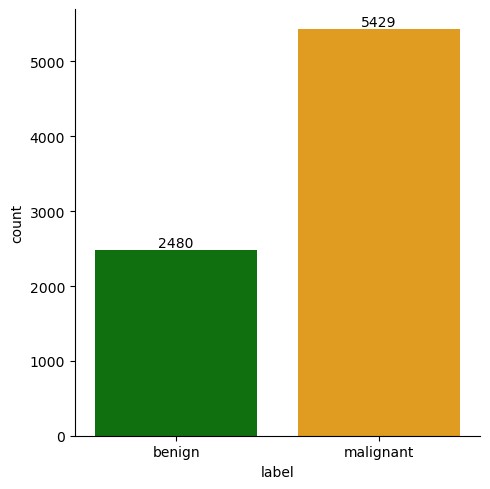

In [12]:
g = sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)
plt.show()

# Converting Categorical Labels to Integer Labels

*apply(lambda x: ['benign', 'malignant'].index(x)): The apply function is used to apply a lambda function to each element in the label column.* <br> *train_test_split(): This function from sklearn.model_selection splits the data into training and testing sets.* <br> 
*test_size=0.2: Specifies that 20% of the data should be used as the test set, and the remaining 80% as the training set.* <br> 
*random_state=42: This ensures that the split is reproducible. The random_state parameter seeds the random number generator used to shuffle the data before splitting. By setting it to 42, it ensures that every time we run the code, we get the same train-test split.*

In [15]:
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

# Creating TensorFlow Datasets from Tensor Slices

In [17]:
train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_test, y_test))

# parse_image Function

*tf.io.read_file(path): Reads the contents of the file located at path. The result is a raw byte string.* <br> *tf.image.decode_png(img, channels=3): Decodes the raw byte string into a PNG image. The channels=3 argument specifies that the image should be decoded as a 3-channel (RGB) image, even if the original image is grayscale or has an alpha channel.* <br>
*return img, label: Returns the decoded image along with its associated label. This is important for keeping the image and its label together as they pass through the preprocessing stage.*

In [20]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

# resize_rescale Function

*tf.cast(image, tf.float32): This converts the image pixel values to float32* <br> *tf.image.resize(img, [64, 64]) / 255.0:
Resizes the image to 64x64 pixels. Resizing ensures that all images have the same dimensions, which is necessary for feeding them into a neural network.* <br>
*Divides by 255.0 to normalize the pixel values to the range [0, 1] (since the original pixel values range from 0 to 255). Normalizing inputs helps stabilize and speed up the learning process in neural networks.* <br>
*return img, label: Returns the resized and rescaled image along with its label.*

In [23]:
def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [64, 64]) / 255.0
    return img, label

# augment_image Function

*tf.image.random_flip_left_right(image): This function randomly flips the image horizontally (left-to-right). This helps the model learn that the object being classified might appear in different orientations.* <br>
*tf.image.random_flip_up_down(image): This function randomly flips the image vertically (upside-down). Similar to horizontal flipping, this helps the model learn from different orientations.* <br>
*tf.image.random_brightness(image, max_delta=0.1): This function randomly adjusts the brightness of the image. The max_delta=0.1 parameter controls the maximum change in brightness. This simulates different lighting conditions.* <br>
*tf.image.random_contrast(image, lower=0.9, upper=1.1): This function randomly adjusts the contrast of the image. The lower=0.9 and upper=1.1 parameters control the range of possible contrast adjustments, simulating varying contrast levels in the image.* 

In [26]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

# Applying augmentation and preprocessing it to the training dataset

train_loader: This is the Dataset object that was created earlier, containing tuples of image paths and labels for the training data.
X_trainset: This dataset is ready for training a model. It includes images that have been augmented (to introduce variability), resized, normalized, shuffled, and batched.
X_testset: This dataset is ready for testing the model. It includes images that have been resized, normalized, and batched, but not augmented.

In [29]:
# Apply augmentation to the training dataset
X_trainset = train_loader.map(parse_image).map(augment_image).map(resize_rescale).shuffle(len(X_train)).batch(64)
X_testset = test_loader.map(parse_image).map(resize_rescale).batch(64)

# Creating a Figure for Plotting

*plt.figure(figsize=(15, 15)): This creates a new figure for plotting, with a specified size of 15x15 inches.* <br>
X_trainset.take(9): This takes the first 9 elements (images and labels) from the X_trainset dataset.
*for i, (img, label) in enumerate(): This loop iterates over these 9 elements. i is the loop index, img is the image tensor, and label is the corresponding label tensor.* <br>
*ax = fig.add_subplot(3, 3, i+1): fig.add_subplot(3, 3, i+1): This creates a 3x3 grid of subplots within the figure. The i+1 specifies the position of the current subplot in the grid (since i is zero-based, i+1 makes it one-based).*

2024-08-17 01:35:14.955404: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2882 of 6327
2024-08-17 01:35:24.956446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 6113 of 6327
2024-08-17 01:35:25.611361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-08-17 01:35:25.687735: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


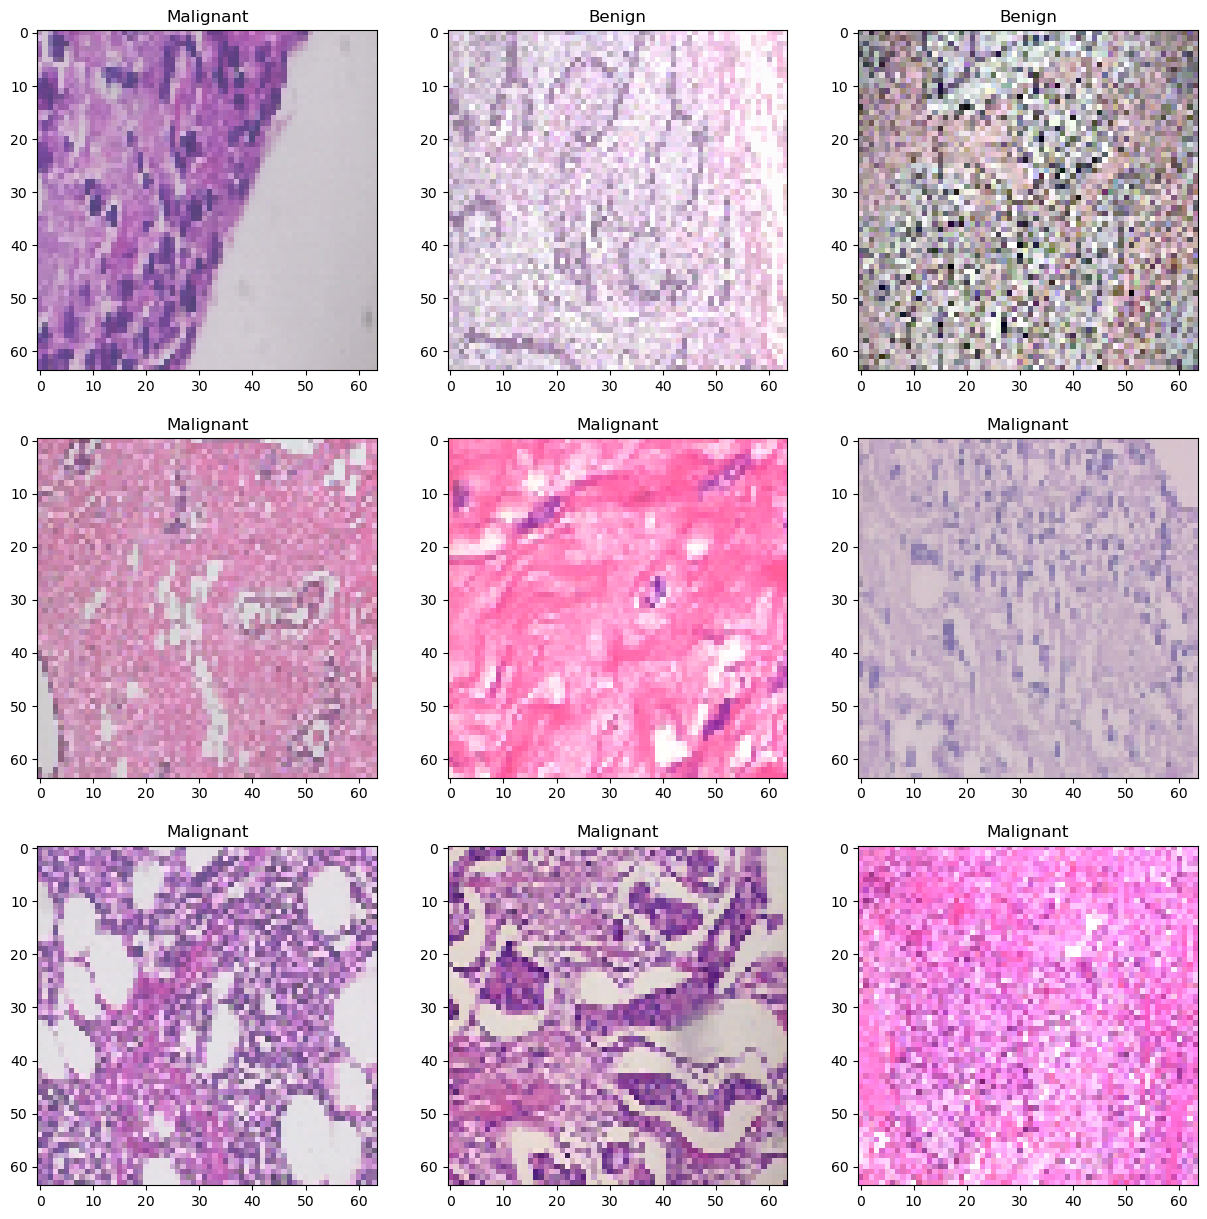

In [32]:
fig = plt.figure(figsize=(15, 15))
for i, (img, label) in enumerate(X_trainset.take(9)):
    ax = fig.add_subplot(3, 3, i+1)
    if tf.keras.backend.get_value(label[i]) == 0:
       ax.title.set_text("Benign")
    else:
       ax.title.set_text("Malignant")
    plt.imshow(img[i])
plt.show()

# Defining the Input Shape, Building the Model, Compiling the Model and Visualizing the Model Summary

*img_shape = (64, 64, 3): This variable defines the shape of the input images: 64, 64: The images are 64x64 pixels.* <br> *model.compile(): Configures the learning process of the model.* <br> *models.Sequential(): This creates a Sequential model in Keras, which means the layers will be added to the model one by one.* <br>
*optimizer="adam": Uses the Adam optimizer, which is an adaptive learning rate optimization algorithm that is widely used because it is efficient and works well on many problems.* <br> *loss="sparse_categorical_crossentropy": This loss function is used for multi-class classification problems when the labels are integers (not one-hot encoded).*

In [35]:
img_shape = (64, 64, 3)
model = models.Sequential([
    Input(shape=img_shape),
    layers.Conv2D(32, 5, padding='same', activation='relu', strides=(1, 1)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
    layers.Conv2D(64, 5, activation='relu', strides=(1, 1)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
    layers.Conv2D(128, 5, activation='relu', strides=(1, 1)),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(1, 1)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(2, activation="softmax")
])
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    20,480,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,742,978 (79.13 MB)

 Trainable params: 20,742,978 (79.13 MB)

 Non-trainable params: 0 (0.00 B)

# Visualizing the Model Training Performance: Accuracy and Loss Over Epochs

*history.history['accuracy']: history is typically the output of the model.fit() method in Keras, which contains the training history.* <br>
*history.history['accuracy'] is a list of accuracy values for the training data across each epoch.* <br> *history.history['val_accuracy']: This is a list of accuracy values for the validation data* <br> *ax1.plot(..., label='validation'): Plots the validation accuracy over epochs on the same subplot ax1.* <br> *ax1.set_title('Accuracy'): Sets the title of the subplot to "Accuracy".* <br> *ax1.set_ylabel('Accuracy score'): Labels the y-axis as "Accuracy score".* <br> *ax1.set_xlabel('Epoch'): Labels the x-axis as "Epoch".* <br> *ax1.legend(): Adds a legend to ax1 to distinguish between the training and validation accuracy lines.* <br> <br> *history.history['loss']: history.history['loss'] is a list of loss values for the training data across each epoch.* <br> *ax2.plot(  label='train'): Plots the training loss over epochs on ax2, the second subplot. The line is labeled 'train' for the legend.* <br>
*history.history['val_loss']: This is a list of loss values for the validation data.* <br> *ax2.plot(..., label='validation'): Plots the validation loss over epochs on the same subplot ax2.* <br> *ax2.set_title('Loss'): Sets the title of the subplot to "Loss".* <br> *ax2.set_ylabel('Loss'): Labels the y-axis as "Loss".* <br> *ax2.set_xlabel('Epoch'): Labels the x-axis as "Epoch".* <br> *ax2.legend(): Adds a legend to ax2 to distinguish between the training and validation loss lines.*

In [38]:
def plotTrainingHistory(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='train')
    ax1.plot(history.history['val_accuracy'], label='validation')
    ax1.set_title('Accuracy')
    ax1.set_ylabel('Accuracy score')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history.history['loss'], label='train')
    ax2.plot(history.history['val_loss'], label='validation')
    ax2.set_title('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.show()

# Computing Class Weights

*compute_class_weight: Calculates weights for each class based on their frequency in the training data to handle class imbalance.* <br>
*Dictionary Creation: Converts the array of class weights into a dictionary where each class label is mapped to its corresponding weight.* <br>
*This is done to ensure that the model treats all classes fairly during training, even when some classes are underrepresented in the dataset.*

In [41]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Implementing Early Stopping and Training with Class Weights

*monitor="val_loss": The metric to monitor during training. In this, it monitors the validation loss (val_loss).* <br>
*mode="min": Specifies that the training should stop when the val_loss has stopped decreasing (i.e., when it has reached a minimum).* <br>
*patience=5: This parameter defines how many epochs the model should wait after the last improvement in validation loss before stopping. If the validation loss does not improve for 5 consecutive epochs, training will stop.* <br>
*restore_best_weights=True: After stopping, the model's weights are restored to the values from the epoch where the validation loss was at its best. This ensures that the model returns to its best state before overfitting began.* <br> *verbose=1: Controls the verbosity of the training output. A value of 1 means progress will be printed for each epoch.* <br> *plotTrainingHistory(history):
This function plots the accuracy and loss of the model over the training epochs for both the training and validation sets.*

Epoch 1/25


2024-08-17 01:35:36.813524: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2866 of 6327
2024-08-17 01:35:47.825491: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.6021 - loss: 1.2352 - val_accuracy: 0.6245 - val_loss: 0.7750
Epoch 2/25


2024-08-17 01:37:49.172146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2961 of 6327
2024-08-17 01:38:00.031652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7447 - loss: 0.5482 - val_accuracy: 0.8312 - val_loss: 0.4428
Epoch 3/25


2024-08-17 01:40:06.344541: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2827 of 6327
2024-08-17 01:40:17.975425: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.7920 - loss: 0.5201 - val_accuracy: 0.8300 - val_loss: 0.4796
Epoch 4/25


2024-08-17 01:42:28.835860: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2839 of 6327
2024-08-17 01:42:38.835215: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5911 of 6327
2024-08-17 01:42:40.143055: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7160 - loss: 0.5731 - val_accuracy: 0.3224 - val_loss: 0.6942
Epoch 5/25


2024-08-17 01:44:48.393105: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2819 of 6327
2024-08-17 01:44:59.877396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.5204 - loss: 0.6914 - val_accuracy: 0.3224 - val_loss: 0.6932
Epoch 6/25


2024-08-17 01:47:08.809556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2785 of 6327
2024-08-17 01:47:20.367514: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.3183 - loss: 0.6975 - val_accuracy: 0.3224 - val_loss: 0.6935
Epoch 7/25


2024-08-17 01:49:30.162156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2748 of 6327
2024-08-17 01:49:42.165810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.5985 - loss: 0.6903 - val_accuracy: 0.3224 - val_loss: 0.6943
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - accuracy: 0.8289 - loss: 0.4413


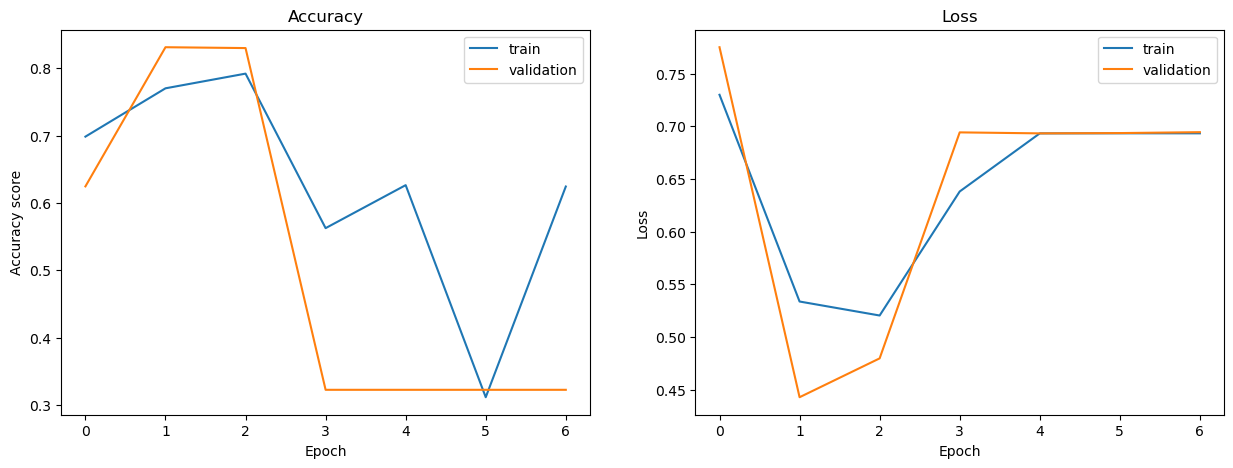

In [44]:
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
history = model.fit(X_trainset, epochs=25, verbose=1, validation_data=X_testset, callbacks=[earlystopping], class_weight=class_weights)
score = model.evaluate(X_testset)
plotTrainingHistory(history)

# Generating and Comparing Predictions on the Test Set

*model.predict(X_testset): This function runs the trained model on the test dataset (X_testset) and generates predictions for each input sample.* <br> *tf.argmax(y_test_pred, axis=1): tf.argmax is a TensorFlow function that returns the index of the maximum value along a specified axis.* <br> *axis=1: Specifies that the function should look at each row (each prediction) in y_test_pred and find the index of the highest probability. Since the model output represents probabilities for two classes (e.g., 0 for benign and 1 for malignant), tf.argmax returns 0 if the first probability is higher and 1 if the second probability is higher.* <br>
*predicted_categories: This variable stores the predicted class labels (either 0 or 1) for each sample in the test set.* <br> *true_categories: This variable contains the true class labels for all samples in the test set, combined into one tensor.*

In [47]:
y_test_pred = model.predict(X_testset)
predicted_categories = tf.argmax(y_test_pred, axis=1)
true_categories = tf.concat([y for x, y in X_testset], axis=0)

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 416ms/step


2024-08-17 01:52:10.352783: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Evaluating Model Performance with Classification Report and Confusion Matrix with normalization

*classification_report(true_categories, predicted_categories, target_names=["Benign", "Malignant"]):* <br> *classification_report: A function from sklearn.metrics that generates a text report showing the main classification metrics: precision, recall, F1-score, and support.* <br>
*true_categories: The true class labels from the test set.* <br>
*predicted_categories: The class labels predicted by the model.* <br>
*target_names=["Benign", "Malignant"]: Assigns the names "Benign" and "Malignant" to the class labels 0 and 1, respectively, in the report.* <br> *confusion_matrix(true_categories, predicted_categories, normalize='true'):* <br> *normalize='true': Normalizes the confusion matrix by dividing each entry by the sum of the true instances for each class.* <br> *Conf_mat: Stores the resulting normalized confusion matrix.*
<br> *sns.heatmap(conf_mat, annot=True, fmt='.4g'):sns.heatmap: A function from Seaborn, a data visualization library, that creates a heatmap from the confusion matrix.* <br>  *conf_mat: The normalized confusion matrix to be visualized.*

              precision    recall  f1-score   support

      Benign       0.75      0.71      0.73       510
   Malignant       0.86      0.89      0.88      1072

    accuracy                           0.83      1582
   macro avg       0.81      0.80      0.80      1582
weighted avg       0.83      0.83      0.83      1582



<Axes: >

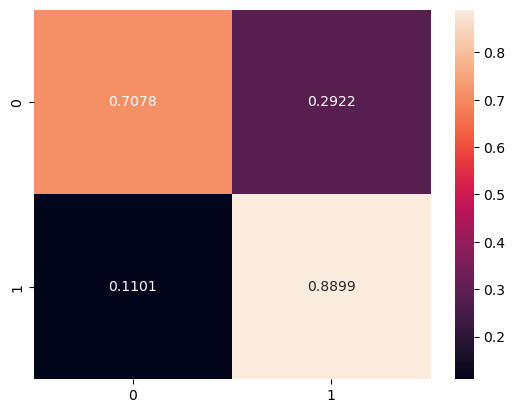

In [50]:
print(classification_report(true_categories, predicted_categories, target_names=["Benign", "Malignant"]))
conf_mat = confusion_matrix(true_categories, predicted_categories, normalize='true')
sns.heatmap(conf_mat, annot=True, fmt='.4g')

# Plotting the Percentage of Correctly Classified Images by Class

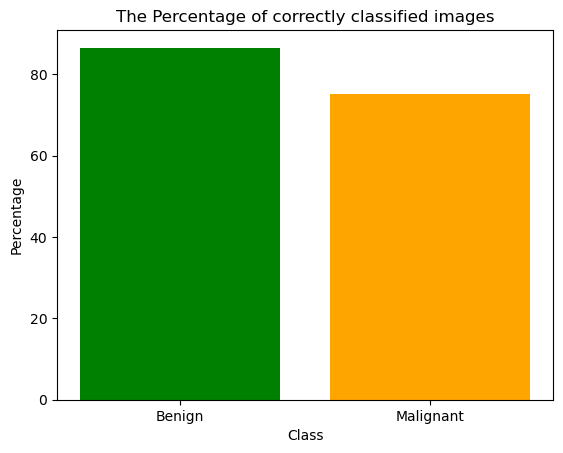

In [52]:
def plotScoresHist(conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("The Percentage of correctly classified images")
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

plotScoresHist(conf_mat)

# Plotting the Receiver Operating Characteristic (ROC) Curve and Calculating AUC

*model.predict(X_testset): This function generates the predicted probabilities for each class for the samples in the test set (X_testset).* <br> *y_test_pred_prob: This variable stores the predicted probabilities for both classes.* <br> *np.concatenate([y for x, y in X_testset]): This concatenates the true labels for all the samples in the test set into a single array (true_categories).* <br>
*y_test_pred_prob_class1 = y_test_pred_prob[:, 1]:y_test_pred_prob[:, 1]: Extracts the predicted probabilities for class 1 (e.g., "Malignant") from the y_test_pred_prob array. These probabilities are used to compute the ROC curve.* <br> *roc_curve: This function computes the False Positive Rate (FPR) and True Positive Rate (TPR) at various threshold settings.* <br> *FPR: The proportion of negative samples that were incorrectly classified as positive.* <br> *TPR (Sensitivity or Recall): The proportion of positive samples that were correctly classified as positive.* <br> *The ROC curve plots TPR against FPR for different threshold values.* <br>
*roc_auc = auc(fpr, tpr):auc(fpr, tpr): This function calculates the Area Under the ROC Curve (AUC). The AUC is a single scalar value that summarizes the performance of the model across all threshold values.* <br> *roc_auc: The AUC value, which ranges from 0 to 1. A value closer to 1 indicates better model performance.*

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 423ms/step


2024-08-17 01:52:23.342660: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


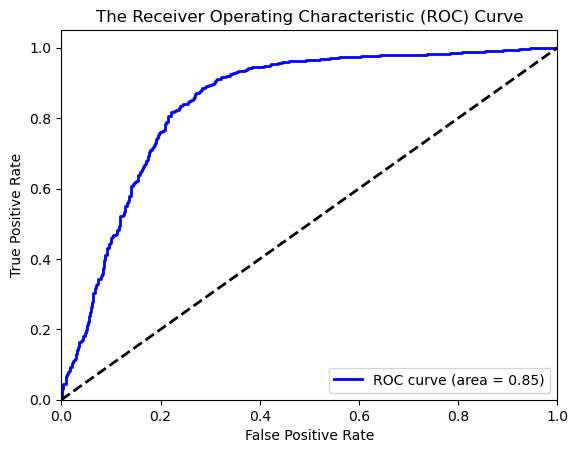

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_pred_prob = model.predict(X_testset)

true_categories = np.concatenate([y for x, y in X_testset])
y_test_pred_prob_class1 = y_test_pred_prob[:, 1]

fpr, tpr, _ = roc_curve(true_categories, y_test_pred_prob_class1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='blue', lw=lw, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Confusion Matrix without Normalization

In [77]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


In [89]:
y_test_pred = model.predict(X_testset)
predicted_categories = tf.argmax(y_test_pred, axis=1)  
true_categories = np.concatenate([y for x, y in X_testset], axis=0)  

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 342ms/step


2024-08-17 02:03:32.808634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [90]:
cm = confusion_matrix(true_categories, predicted_categories) 

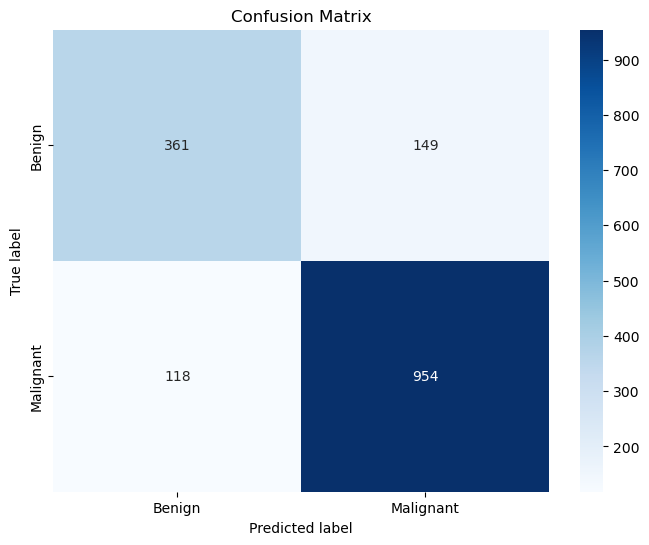

In [91]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
